In [1]:
import math 
from scipy.stats import randint
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

In [91]:
def sample_Dfar_easy():
    # Create the D_far probability vector once
    S = set(random.sample(range(m), int(epsilon * m)))
    
    #prob = [0] * n
    prob=np.zeros(m)
    for i in range(m):
        if i in S:
            prob[i] = (1/m) + (2*epsilon/m)
        else:
            prob[i] = (1/m) - (2*epsilon/(m*(1-epsilon)))
    
    # Normalize just in case (tiny numerical errors)
    #total_prob = sum(prob)
    #prob = [p/total_prob for p in prob]
    prob /=prob.sum()
    
    return prob

In [105]:
def paninski_dfar():
    """
    Implements Paninski's hard ε-far distribution from Section 3:
    q(i) = (1 + ε z_{i/2}) / m,   if i is even
           (1 - ε z_{(i+1)/2}) / m, if i is odd
    """

    assert m % 2 == 0, "m must be even for Paninski's construction."

    half_m = m // 2
    z = np.random.choice([-1, 1], size=half_m+1)  # z_j ∈ {−1, +1}

    q = np.zeros(m)
    for i in range(m):
        if i % 2 == 0:  # even index
            idx = i // 2
            q[i] = (1 + epsilon * z[idx]) / m
        else:  # odd index
            idx = (i + 1) // 2
            q[i] = (1 - epsilon * z[idx]) / m

    # Normalize for safety (though it should already sum to 1)
    q /= q.sum()
    return q

In [20]:
def generate_samples_uniform(m, s):
    """Generate s samples from uniform distribution over m bins."""
    return np.random.choice(m, size=s)

In [21]:
def sample_Dfar_many(prob, m, s):
    #return random.choices(range(1, m+1), weights=prob, k=s)
    return np.random.choice(m, size=s_test, p=prob_Dfar)

In [22]:
def compute_T(samples, m, s):
    """
    Compute Paninski's test statistic T for a given sample.
    """
    # Count how many times each bin is hit
    bin_counts = Counter(samples)
    
    # Count number of singletons (bins hit exactly once)
    K1 = sum(1 for count in bin_counts.values() if count == 1)
    
    # Expected number of singletons under uniform
    EU_K1 = s * ((m-1)/m)**(s-1)
    
    # Compute test statistic
    T = EU_K1 - K1
    
    return T

In [23]:
def find_threshold_paninski(T_uniform, T_Dfar, delta):
    """
    Find threshold T* based on percentile separation like you did before.
    """
    num_samples = len(T_uniform)
    
    # Sort the T values
    T_uniform.sort()
    T_Dfar.sort()
    
    # Find thresholds
    idx_u = int(np.floor((1 - delta) * num_samples))
    threshold_u = T_uniform[idx_u]
    
    idx_d = int(np.floor(delta * num_samples))
    threshold_d = T_Dfar[idx_d]
    
    # Check separation
    if threshold_u < threshold_d:
        # Pick any value between threshold_u and threshold_d
        t_test = (threshold_u + threshold_d) / 2
        return t_test
    else:
        return None  # Means s is too small, need larger s

In [98]:
def find_s_and_t_paninski(m, epsilon, delta, sample_Dfar, s_test):
    """
    Find suitable s and T* adaptively for Paninski's test.
    
    sample_Dfar_func: function that returns samples from a distribution ε-far from uniform
    """

    s_test = 1000  # initial guess for s

    while True:
        T_uniform = []
        T_Dfar = []

        # Generate fixed far-from-uniform distribution if needed
        prob_Dfar = sample_Dfar()

        for _ in range(100):
            # Generate samples
            samples_uniform = np.random.choice(m, size=s_test)
            samples_Dfar = np.random.choice(m, size=s_test, p=prob_Dfar)

            # Compute T statistics
            T_uniform.append(compute_T(samples_uniform, m, s_test))
            T_Dfar.append(compute_T(samples_Dfar, m, s_test))

        # Try to find a good threshold
        t_test = find_threshold_paninski(T_uniform, T_Dfar, delta)
        
        print("Finished")

        if t_test is not None:
            return s_test, t_test  # found good s and t
        else:
            # Increase s gradually
            s_test = int(s_test * 1.1)
            
            # Important: cap s to avoid s > m/2
            #if s_test > m // 2:
            #    raise ValueError("s became too large (exceeding m/2), cannot find good threshold.")


In [82]:
m=10000
epsilon=0.3
delta=0.3
find_s_and_t_paninski(m, epsilon, delta, max_trials=100)

(1331, 5.736288233079449)

In [39]:
def plot_collision_distributions(num_collisions_uniform, num_collisions_Dfar, threshold_t=None):
    plt.figure(figsize=(10,6))
    
    # Plot histograms
    plt.hist(num_collisions_uniform, bins=30, alpha=0.6, label='Uniform', color='blue', density=True)
    plt.hist(num_collisions_Dfar, bins=30, alpha=0.6, label='D_far', color='red', density=True)
    
    # Plot threshold if given
    if threshold_t is not None:
        plt.axvline(threshold_t, color='black', linestyle='dashed', label=f'Threshold t = {threshold_t:.2f}')
    
    plt.xlabel('Number of Singleton')
    plt.ylabel('Density')
    plt.title('Singleton Distributions for Uniform vs D_far')
    plt.legend()
    plt.grid(True)
    plt.show()

In [74]:
s_test=1464
num_collisions_uniform = []
num_collisions_Dfar = []

prob_Dfar = paninski_dfar(m, epsilon)

for _ in range(100):  # 100 repetitions (you can increase it)
    samples_from_uniform = list(randint.rvs(1, m+1, size=s_test))
    samples_from_Dfar = sample_Dfar_many(prob_Dfar, m, s_test)
    
    num_collisions_uniform.append(compute_T(samples_from_uniform, m, s_test))
    num_collisions_Dfar.append(compute_T(samples_from_Dfar, m, s_test))

    
num_collisions_uniform.sort()
num_collisions_Dfar.sort()

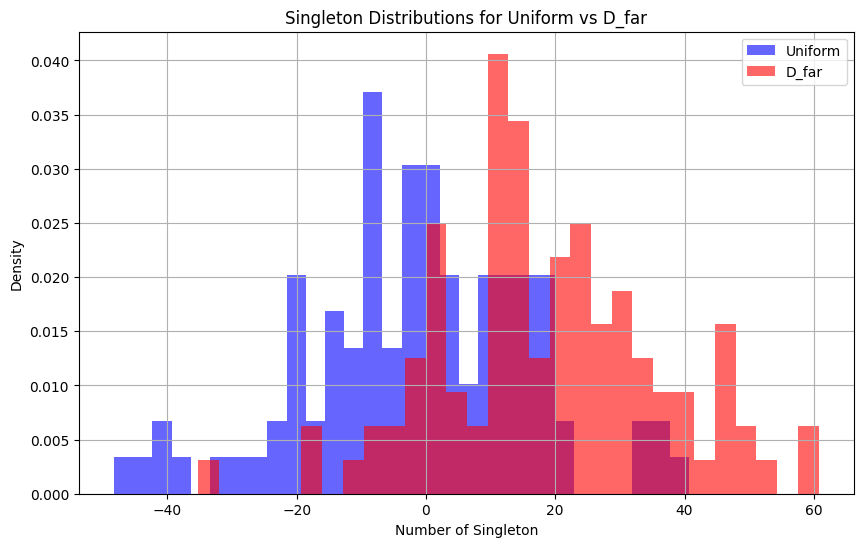

In [75]:
plot_collision_distributions(num_collisions_uniform, num_collisions_Dfar, threshold_t=None)

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def find_auto_threshold(num_collisions_uniform, num_collisions_Dfar, plot=True):
    # Kernel density estimation
    kde_u = gaussian_kde(num_collisions_uniform)
    kde_d = gaussian_kde(num_collisions_Dfar)
    
    # Create a fine grid over the collision values
    x_grid = np.linspace(min(min(num_collisions_uniform), min(num_collisions_Dfar)),
                         max(max(num_collisions_uniform), max(num_collisions_Dfar)), 1000)
    
    u_density = kde_u(x_grid)
    d_density = kde_d(x_grid)
    
    # Find where Uniform's density crosses below Dfar's density
    crossover_indices = np.where(u_density < d_density)[0]
    
    if len(crossover_indices) == 0:
        print("No clear crossover found — maybe s is too small?")
        return None
    
    # Pick the first crossover point
    crossover_idx = crossover_indices[0]
    threshold_t = x_grid[crossover_idx]
    
    if plot:
        plt.figure(figsize=(10,6))
        plt.plot(x_grid, u_density, label='Uniform density', color='blue')
        plt.plot(x_grid, d_density, label='D_far density', color='red')
        plt.axvline(threshold_t, color='black', linestyle='dashed', label=f'Suggested t = {threshold_t:.2f}')
        plt.xlabel('Number of Collisions')
        plt.ylabel('Density')
        plt.title('Density Curves and Automatic Threshold')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return threshold_t

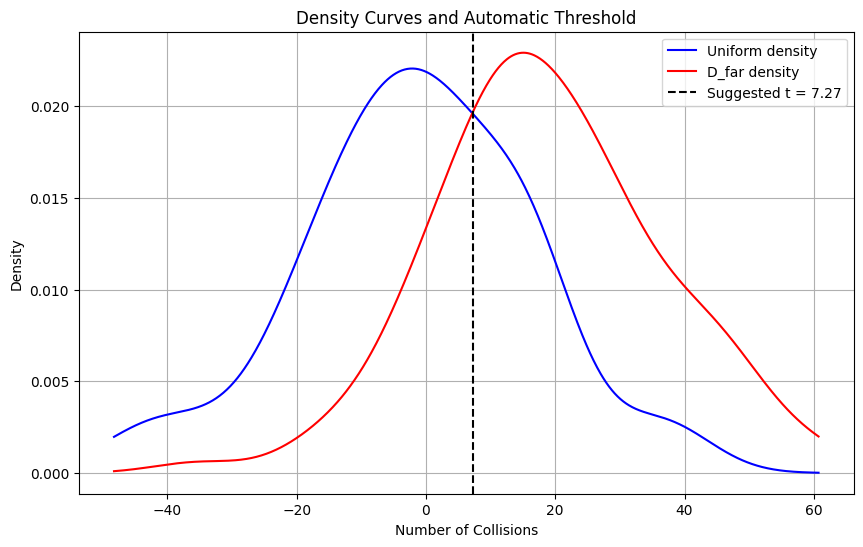

In [77]:
t_test1 = find_auto_threshold(num_collisions_uniform, num_collisions_Dfar)

In [59]:
t_test1

35.54743286717817

In [2]:
def paninski_uniformity_test(m, s, samples, threshold_T_star):
    """
    Paninski's Uniformity Test
    
    Parameters:
    m: int
        Number of bins (support size)
    s: int
        Number of samples to draw
    samples: list or np.array
        List of samples drawn from the unknown distribution D
    threshold_T_star: float
        Threshold for the test statistic T
        
    Returns:
    decision: str
        "Reject H0: Not uniform" or "Fail to reject H0: Uniform"
    """

    # 1. Count how many times each bin is hit
    bin_counts = Counter(samples)
    
    # 2. Count number of singletons (bins hit exactly once)
    K1 = sum(1 for count in bin_counts.values() if count == 1)
    
    # 3. Compute expected number of singletons under uniform
    EU_K1 = s * ((m-1)/m)**(s-1)
    
    # 4. Compute the test statistic
    T = EU_K1 - K1
    
    # 5. Decision rule
    if T > threshold_T_star:
        return "Reject H0: Not uniform"
    else:
        return "Fail to reject H0: Uniform"

In [3]:
m = 1000           # Number of bins
epsilon = 0.1      # Distance parameter
s = int(np.ceil(np.sqrt(m) / (epsilon**2)))   # Sample size


In [ ]:
# Generate samples from uniform distribution (for testing)
samples = generate_samples_uniform(m, s)

# Define threshold T*
threshold_T_star = (s**2 * epsilon**2) / (2 * m)

# Run Paninski's test
decision = paninski_uniformity_test(m, s, samples, threshold_T_star)

print("Decision:", decision)

In [4]:
s

3163

## For old Dfar:

In [119]:
old_uniform_easy_s=[]

In [92]:
m=10000
epsilon=0.2
delta=0.1
find_s_and_t_paninski(m, epsilon, delta, sample_Dfar=sample_Dfar_easy, s_test=1000)

Finished
Finished
Finished
Finished
Finished
Finished
Finished


(1771, 32.694866757123464)

In [120]:
#STORE VALUES HERE:
m=10000
epsilon=0.2
delta=0.1
for i in range(10):
    old_uniform_easy_s +=[find_s_and_t_paninski(m, epsilon, delta, sample_Dfar=sample_Dfar_easy, s_test=300)]
    

Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished


In [121]:
old_uniform_easy_s

[(1331, 21.73628823307945),
 (1610, 28.206271247589257),
 (1331, 18.23628823307945),
 (1464, 25.238144113932094),
 (1610, 26.206271247589257),
 (1610, 29.706271247589257),
 (1464, 27.238144113932094),
 (1771, 29.694866757123464),
 (1331, 17.73628823307945),
 (1464, 25.738144113932094)]

In [99]:
s_test=1771
num_collisions_uniform = []
num_collisions_Dfar = []

prob_Dfar = sample_Dfar_easy()

for _ in range(100):  # 100 repetitions (you can increase it)
    samples_from_uniform = list(randint.rvs(1, m+1, size=s_test))
    samples_from_Dfar = sample_Dfar_many(prob_Dfar, m, s_test)

    num_collisions_uniform.append(compute_T(samples_from_uniform, m, s_test))
    num_collisions_Dfar.append(compute_T(samples_from_Dfar,m, s_test))

num_collisions_uniform.sort()
num_collisions_Dfar.sort()

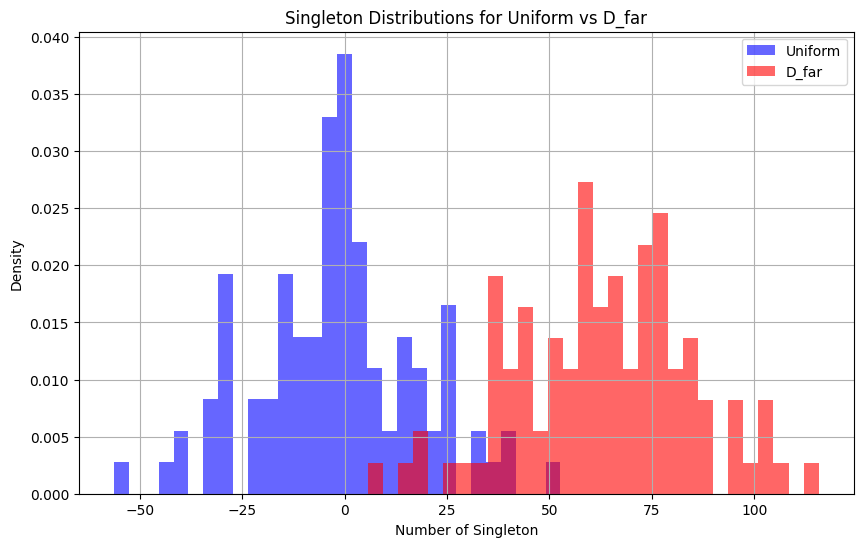

In [100]:
plot_collision_distributions(num_collisions_uniform, num_collisions_Dfar, threshold_t=None)

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def find_auto_threshold(num_collisions_uniform, num_collisions_Dfar, plot=True):
    # Kernel density estimation
    kde_u = gaussian_kde(num_collisions_uniform)
    kde_d = gaussian_kde(num_collisions_Dfar)
    
    # Create a fine grid over the collision values
    x_grid = np.linspace(min(min(num_collisions_uniform), min(num_collisions_Dfar)),
                         max(max(num_collisions_uniform), max(num_collisions_Dfar)), 1000)
    
    u_density = kde_u(x_grid)
    d_density = kde_d(x_grid)
    
    # Find where Uniform's density crosses below Dfar's density
    crossover_indices = np.where(u_density < d_density)[0]
    
    if len(crossover_indices) == 0:
        print("No clear crossover found — maybe s is too small?")
        return None
    
    # Pick the first crossover point
    crossover_idx = crossover_indices[0]
    threshold_t = x_grid[crossover_idx]
    
    if plot:
        plt.figure(figsize=(10,6))
        plt.plot(x_grid, u_density, label='Uniform density', color='blue')
        plt.plot(x_grid, d_density, label='D_far density', color='red')
        plt.axvline(threshold_t, color='black', linestyle='dashed', label=f'Suggested t = {threshold_t:.2f}')
        plt.xlabel('Number of Collisions')
        plt.ylabel('Density')
        plt.title('Density Curves and Automatic Threshold')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return threshold_t

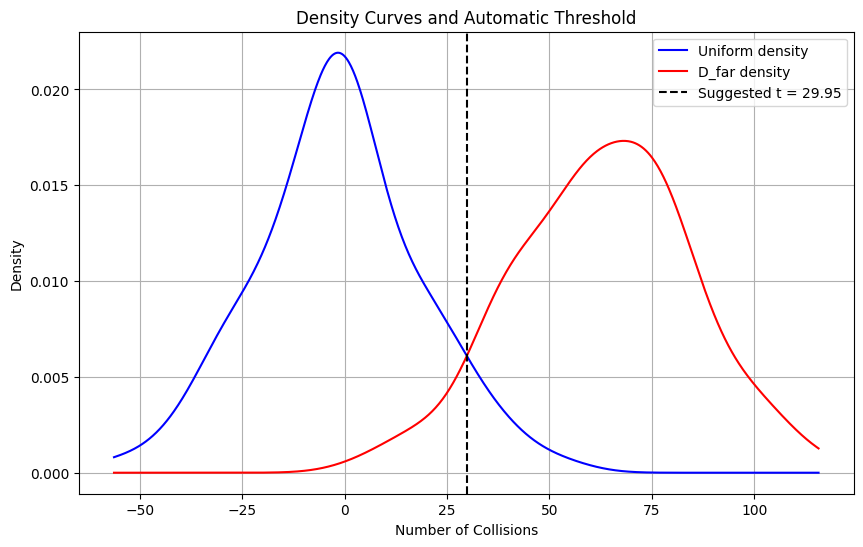

In [102]:
t_test1 = find_auto_threshold(num_collisions_uniform, num_collisions_Dfar)

In [103]:
t_test1

29.95312501538173

In [130]:
old_uniform_easy_s

[(1331, 21.73628823307945),
 (1610, 28.206271247589257),
 (1331, 18.23628823307945),
 (1464, 25.238144113932094),
 (1610, 26.206271247589257),
 (1610, 29.706271247589257),
 (1464, 27.238144113932094),
 (1771, 29.694866757123464),
 (1331, 17.73628823307945),
 (1464, 25.738144113932094)]

In [131]:
old_s_values=[pair[0] for pair in old_uniform_easy_s]

In [132]:
np.mean(old_s_values)

1498.6

## For Paninski's Dfar:

In [124]:
paninski_Dfar_s=[]

In [106]:
m=10000
epsilon=0.3
delta=0.3
find_s_and_t_paninski(m, epsilon, delta, sample_Dfar=paninski_dfar, s_test=1000)

Finished
Finished
Finished
Finished
Finished


(1464, 10.238144113932094)

In [125]:
#STORE VALUES HERE:
m=10000
epsilon=0.3
delta=0.3
for i in range(10):
    paninski_Dfar_s +=[find_s_and_t_paninski(m, epsilon, delta, sample_Dfar=paninski_dfar, s_test=1000)]
    

Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished


In [107]:
s_test=1464
num_collisions_uniform = []
num_collisions_Dfar = []

prob_Dfar = paninski_dfar()

for _ in range(100):  # 100 repetitions (you can increase it)
    samples_from_uniform = list(randint.rvs(1, m+1, size=s_test))
    samples_from_Dfar = sample_Dfar_many(prob_Dfar, m, s_test)

    num_collisions_uniform.append(compute_T(samples_from_uniform, m, s_test))
    num_collisions_Dfar.append(compute_T(samples_from_Dfar,m, s_test))

num_collisions_uniform.sort()
num_collisions_Dfar.sort()

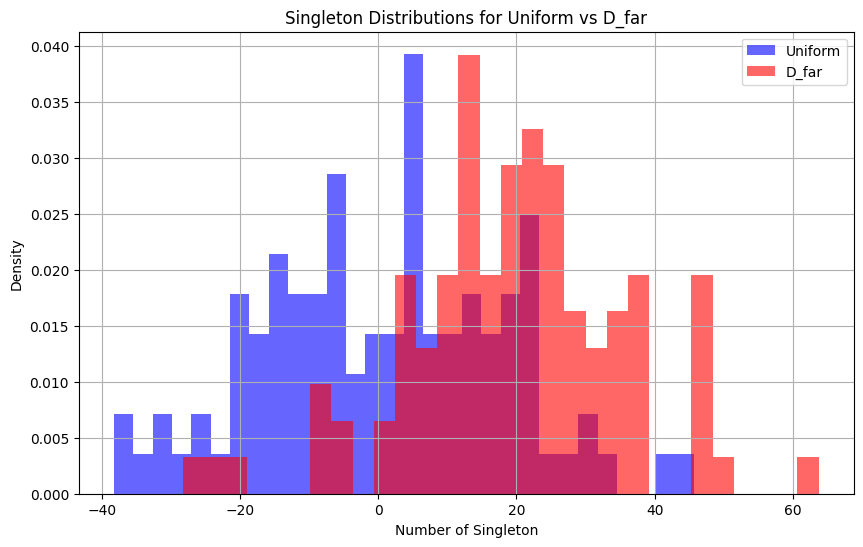

In [108]:
plot_collision_distributions(num_collisions_uniform, num_collisions_Dfar, threshold_t=None)

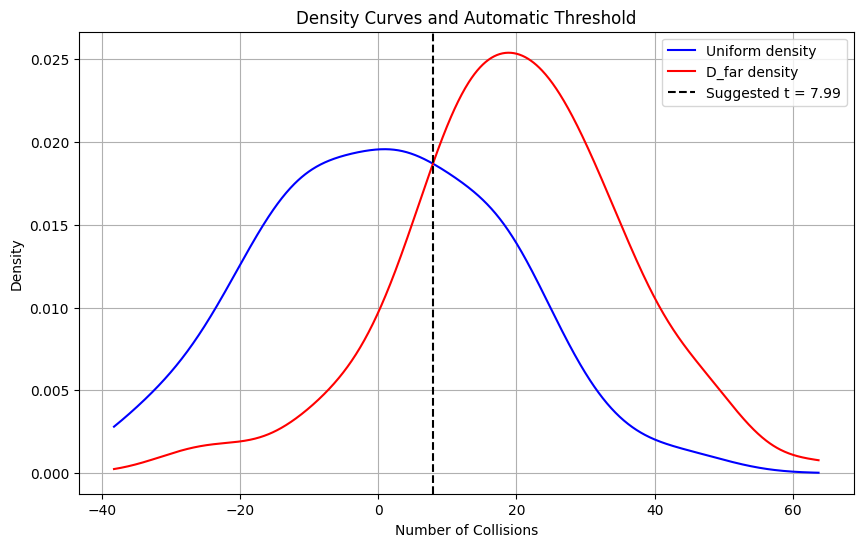

In [109]:
t_test1 = find_auto_threshold(num_collisions_uniform, num_collisions_Dfar)

In [126]:
paninski_Dfar_s

[(1610, 12.206271247589257),
 (1610, 11.206271247589257),
 (1610, 6.206271247589257),
 (1771, 12.694866757123464),
 (1610, 11.706271247589257),
 (1464, 7.238144113932094),
 (1771, 10.694866757123464),
 (1331, 6.236288233079449),
 (1610, 11.206271247589257),
 (1771, 12.194866757123464)]

In [128]:
paninski_s_values=[pair[0] for pair in paninski_Dfar_s]

In [129]:
np.mean(paninski_s_values)

1615.8

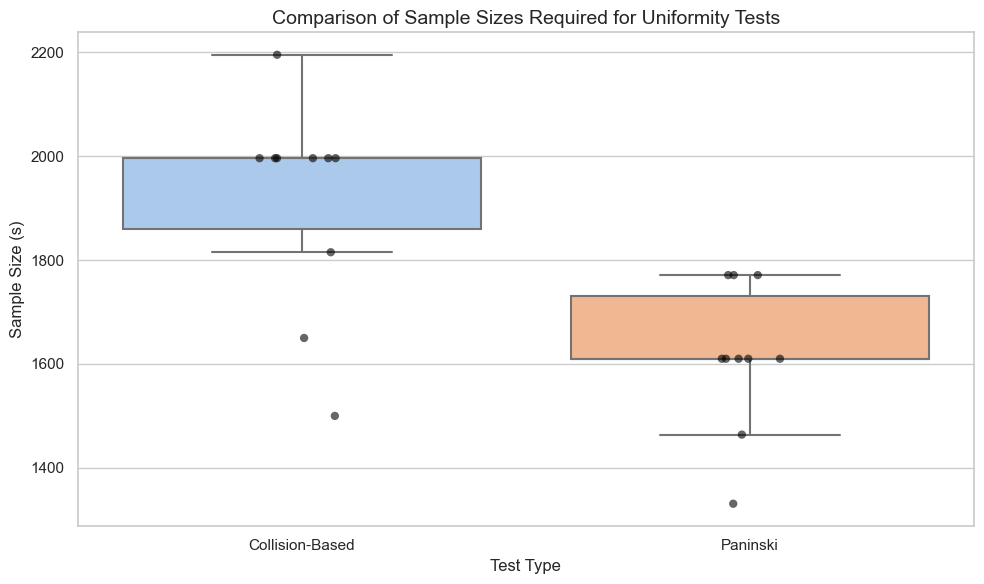

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data from your results
collision_s = [1996, 1996, 1815, 1996, 1500, 1650, 1996, 1996, 1996, 2195]
paninski_s = [1610, 1610, 1610, 1771, 1610, 1464, 1771, 1331, 1610, 1771]

# Prepare DataFrame for seaborn
df = pd.DataFrame({
    'Sample Size': collision_s + paninski_s,
    'Test': ['Collision-Based'] * len(collision_s) + ['Paninski'] * len(paninski_s)
})

# Set the style
sns.set(style="whitegrid")

# Create boxplot + stripplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Test', y='Sample Size', data=df, palette='pastel', showfliers=False)
sns.stripplot(x='Test', y='Sample Size', data=df, color='black', jitter=True, size=6, alpha=0.6)

# Optional violin plot (uncomment to use instead of boxplot)
# plt.figure(figsize=(10, 6))
# sns.violinplot(x='Test', y='Sample Size', data=df, inner='quartile', palette='muted')

# Titles and labels
plt.title('Comparison of Sample Sizes Required for Uniformity Tests', fontsize=14)
plt.xlabel('Test Type')
plt.ylabel('Sample Size (s)')
plt.tight_layout()
plt.show()

In [135]:
prev_s_values0=[1331,1331,1331,1464,1464, 1610, 1464,1331,1610,1331]
paninski_s_values0=[1331, 1610, 1331, 1464, 1610, 1610, 1464, 1771, 1331, 1464]

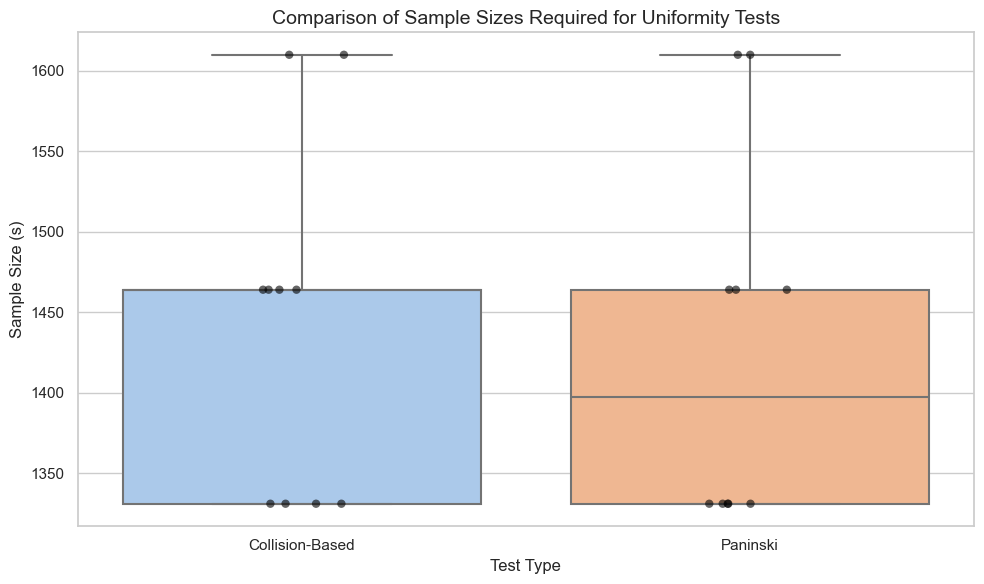

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data from your results
collision_s0 = [1331,1331,1331,1464,1464, 1610, 1464,1331,1610,1464]
paninski_s0 = [1331, 1331, 1331, 1464, 1610, 1610, 1464, 1331, 1331, 1464]

# Prepare DataFrame for seaborn
df = pd.DataFrame({
    'Sample Size': collision_s0 + paninski_s0,
    'Test': ['Collision-Based'] * len(collision_s0) + ['Paninski'] * len(paninski_s0)
})

# Set the style
sns.set(style="whitegrid")

# Create boxplot + stripplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Test', y='Sample Size', data=df, palette='pastel', showfliers=False)
sns.stripplot(x='Test', y='Sample Size', data=df, color='black', jitter=True, size=6, alpha=0.6)

# Optional violin plot (uncomment to use instead of boxplot)
# plt.figure(figsize=(10, 6))
# sns.violinplot(x='Test', y='Sample Size', data=df, inner='quartile', palette='muted')

# Titles and labels
plt.title('Comparison of Sample Sizes Required for Uniformity Tests', fontsize=14)
plt.xlabel('Test Type')
plt.ylabel('Sample Size (s)')
plt.tight_layout()
plt.show()